# Hybrid Deep Learning Model for Early ASD Detection

## Overview
This notebook implements a **Hybrid CNN-LSTM** model for detecting Autism Spectrum Disorder (ASD) from fMRI time-series data. Unlike traditional machine learning models that flatten the data, this approach preserves the temporal dynamics of brain connectivity.

### Methodology
1. **Data Loading**: Load raw time-series fMRI data.
2. **Data Augmentation**: Use a **sliding window** technique to generate multiple samples per subject. This increases the dataset size and helps the model learn temporal patterns.
3. **Hybrid Model**: Combine **CNN** (for spatial/local feature extraction) and **LSTM** (for temporal sequence modeling).
4. **Evaluation**: Subject-wise cross-validation to ensure robust performance estimation.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow Version: {tf.__version__}")

c:\Users\eredd\Desktop\FYP\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0


## 1. Data Loading and Preprocessing

We define a sliding window function to segment the time-series data. This is critical for Deep Learning on small datasets.

In [2]:
# Configuration
WINDOW_SIZE = 64   # Length of each time segment (e.g., 64 time points)
STRIDE = 32        # Overlap (50% overlap)
BATCH_SIZE = 32
EPOCHS = 50

dataset_path = 'Dataset'
asd_path = os.path.join(dataset_path, 'Training Data', 'ASD')
normal_path = os.path.join(dataset_path, 'Training Data', 'Normal')

def create_windows(data, window_size, stride):
    """Generates sliding windows from time-series data."""
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        window = data[i:i + window_size]
        windows.append(window)
    return np.array(windows)

def load_and_augment_data(folder_path, label, window_size, stride):
    """
    Loads CSV files, standardizes them, and applies sliding window augmentation.
    IMPORTANT: We keep track of subject IDs to ensure proper splitting later.
    """
    X = []
    y = []
    groups = []  # To track which subject a window belongs to
    
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found: {folder_path}")
        return np.array([]), np.array([]), np.array([])
    
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    print(f"Processing {len(csv_files)} files in {folder_path}...")
    
    if len(csv_files) == 0:
        print("Warning: No CSV files found.")
        return np.array([]), np.array([]), np.array([])
    
    for idx, csv_file in enumerate(csv_files):
        try:
            df = pd.read_csv(csv_file)
            # Drop non-feature columns if any (like Unnamed indices)
            if 'Unnamed: 0' in df.columns:
                df = df.drop(columns=['Unnamed: 0'])
            
            # Simple check for numeric data
            if not np.issubdtype(df.values.dtype, np.number):
                 print(f"Warning: Non-numeric data in {os.path.basename(csv_file)}")
                 continue

            # IMPORTANT: Standardization per subject is often good for fMRI
            # to handle inter-subject variability in signal amplitude
            scaler = StandardScaler()
            data_scaled = scaler.fit_transform(df.values)
            
            # Create windows
            subject_windows = create_windows(data_scaled, window_size, stride)
            
            if len(subject_windows) > 0:
                X.append(subject_windows)
                y.extend([label] * len(subject_windows))
                groups.extend([idx] * len(subject_windows)) # Track subject ID
            else:
                 print(f"Warning: File {os.path.basename(csv_file)} resulted in 0 windows (too short?).")
                
        except Exception as e:
            print(f"Error loading {os.path.basename(csv_file)}: {e}")
            
    if len(X) > 0:
        X = np.vstack(X)
        y = np.array(y)
        groups = np.array(groups)
    else:
        X = np.array([])
        y = np.array([])
        groups = np.array([])
    
    return X, y, groups

# Load Data
print("Loading ASD Data...")
X_asd, y_asd, g_asd = load_and_augment_data(asd_path, 1, WINDOW_SIZE, STRIDE)

print("\nLoading Normal Data...")
X_norm, y_norm, g_norm = load_and_augment_data(normal_path, 0, WINDOW_SIZE, STRIDE)

# Handle case where one or both are empty for safety
if len(X_asd) > 0 and len(X_norm) > 0:
    # Adjust group IDs for Normal data so they don't overlap with ASD IDs
    g_norm = g_norm + (g_asd.max() + 1)

    # Combine
    X = np.concatenate([X_asd, X_norm], axis=0)
    y = np.concatenate([y_asd, y_norm], axis=0)
    groups = np.concatenate([g_asd, g_norm], axis=0)

    print("\nData Shapes:")
    print(f"X (features): {X.shape}")
    print(f"y (labels):   {y.shape}")
else:
    print("\nError: Could not load both classes needed for training.")
    X = np.array([])
    y = np.array([])
    groups = np.array([])


Loading ASD Data...
Processing 50 files in Dataset\Training Data\ASD...

Loading Normal Data...
Processing 50 files in Dataset\Training Data\Normal...

Data Shapes:
X (features): (400, 64, 110)
y (labels):   (400,)


## 2. Train/Test Split (Subject-aware)

We must ensure that **all windows from a single subject** end up in EITHER the train set OR the test set. If we split randomly, the model will "memorize" a subject's unique brain signature from the training windows and easily classify the testing windows from the same subject, leading to data leakage and inflated accuracy.

In [3]:
# Improved Splitting Strategy: GroupKFold or Manual Group Split
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training Set: {X_train.shape}")
print(f"Testing Set:  {X_test.shape}")

# Class Balance Check
print(f"Train Balance (ASD/Total): {np.sum(y_train)/len(y_train):.2f}")
print(f"Test Balance (ASD/Total):  {np.sum(y_test)/len(y_test):.2f}")

Training Set: (320, 64, 110)
Testing Set:  (80, 64, 110)
Train Balance (ASD/Total): 0.47
Test Balance (ASD/Total):  0.60


## 3. Hybrid CNN-LSTM Model Architecture

- **Conv1D Layers**: Extract local temporal features and patterns from the multivariate time series.
- **LSTM Layer**: Captures longer-term dependencies and temporal dynamics.
- **Dropout**: Prevents overfitting.

In [4]:
def build_hybrid_model(input_shape):
    model = models.Sequential()
    
    # CNN Block
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))
    
    # LSTM Block
    # return_sequences=False because we want the final state for classification
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dropout(0.4))
    
    # Dense Classification Block
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Dynamic Input Shape based upon loaded data
# X.shape is (Samples, TimeSteps, Features)
input_shape = (WINDOW_SIZE, X.shape[2]) 
print(f"Model Input Shape: {input_shape}")

model = build_hybrid_model(input_shape)
model.summary()

Model Input Shape: (64, 110)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │        35,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,257 (438.50 KB)

 Trainable params: 111,873 (437.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
# Callbacks
# early_stopping = keras.callbacks.EarlyStopping(
#    monitor='val_loss',
#    patience=10,
#    restore_best_weights=True
# )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Train
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4922 - loss: 1.1138 - val_accuracy: 0.0000e+00 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5391 - loss: 1.0535 - val_accuracy: 0.0000e+00 - val_loss: 1.5316 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - loss: 0.9929 - val_accuracy: 0.0000e+00 - val_loss: 1.6032 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6445 - loss: 0.9497 - val_accuracy: 0.0000e+00 - val_loss: 1.6524 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6719 - loss: 0.8942 - val_accuracy: 0.0000e+00 - val_loss: 1.4578 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7344 - loss: 0.8417 - val_accuracy: 0.0000e+00 - val_loss: 1.5492 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7969 - loss: 0.7964

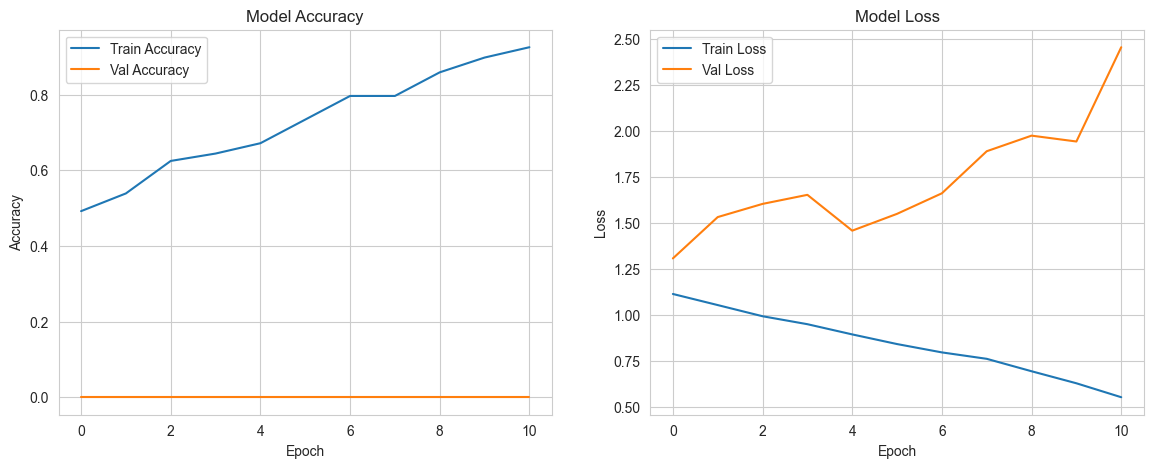

In [6]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 4. Final Evaluation on Test Set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        32
         ASD       0.60      1.00      0.75        48

    accuracy                           0.60        80
   macro avg       0.30      0.50      0.38        80
weighted avg       0.36      0.60      0.45        80

Test Accuracy: 0.6000
AUC-ROC Score: 0.4766


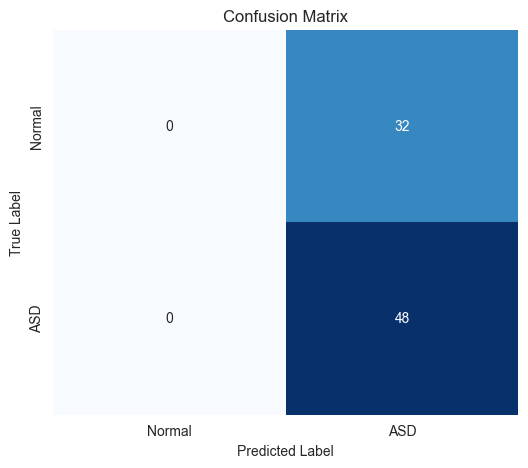

In [7]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'ASD']))

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'ASD'], yticklabels=['Normal', 'ASD'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()